In [ ]:
# Deep Learning Fundamental
# Yanhui Zhao a1832643
# assignment02

In [13]:

import glob
import os
import cv2
import  tensorflow as tf
from tensorflow.keras import layers, optimizers, datasets, Sequential
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import load_model

path = './mammals/'

# Scale image size to 100*100
w = 100
h = 100
# c = 3


In [14]:
### Define image reading functions
# Define the function load_img, which is used to read the image data and to resize the image in a uniform format
def load_img(path): 
    # Create a hierarchical list dir for traversing the data folders below the data storage directory. os.path.isdir is used to determine if a file is a directory, and then traverse the files that are directory files
    dir=[path+x for x in os.listdir(path) if os.path.isdir(path+x)]  
     # Creating an empty list for saving images
    imgs=[]   
    # Create an empty list for saving image labels
    labels=[]    
    # The enumerate function is used to combine an iterable data object into an indexed sequence, listing both data and subscripts, and is generally used in for loops
    # enumerate(cate) -> (0, './mammals/dogs')  Index + Path
    for idx,folder in enumerate(dir):    
        # Use the glob.glob function to search for a specific format "/*.jpg" under each hierarchical file to iterate through and match
        for im in glob.glob(folder+'/*.jpeg'): 
            # Use the imread function to read each image that is traversed
            img=cv2.imread(im)      
            # Use the resize function to scale each img image to a uniform size of w*h (i.e. 100*100)
            img=cv2.resize(img,(w,h))
            # Each processed image data is saved in the empty list of imgs created earlier and eventually all images are stuffed into the imgs list
            imgs.append(img)  
            # Save the label data for each processed image in the list of labels created earlier
            labels.append(idx) 
     # Use the np.asarray function to transform the generated imgs and labels list data into an array (imgs to floating point, labels to integer)        
    return np.asarray(imgs,np.float32),np.asarray(labels,np.int32)   


In [15]:
# get the data and label of the dataset from the image
data,label=load_img(path)    
# get the size of the data  
print("shape of data:",data.shape)              
# get the size of the label   
print("shape of label:",label.shape)      
# get the label list to distinguish the images from different mammal folders
print(label)  


shape of data: (74, 100, 100, 3)
shape of label: (74,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4]


In [16]:
# The random numbers generated are guaranteed to be predictable, i.e. the same seeds (seed values) produce the same random numbers, where the numbers can be taken at random.
seed = 828
# Generate random seeds
np.random.seed(seed)

# split the dataset in to train and test data with 7:3 proportion

x_train, x_val, y_train, y_val = train_test_split(data, label, test_size=0.30, random_state=seed)

# Normalise the data 
# # Since the RGB colours of the image are maximal but (255,255,255) they have to be divided by 255 Normalized to between [0,1], with fractions appearing since they are converted to floating point numbers --- normalized
x_train = x_train / 255 
x_val = x_val / 255
# print(x_train)
# print(x_val)


In [17]:
# Create a list for image labels
mammal_dict = {0:'dogs',1:'cat',2:'dophins',3:'rabbits',4:'sapiens'}

In [18]:
### Designing The Neural Network
# using the sequential model
# Create the model. The model consists of three convolutional layers and three RELU activation functions, two pooling layers
model = Sequential([ 
    # using tf.keras.layers.Conv2D()
    # Number of filters/number of convolution kernels Same number of output channels as after convolution
    # kernel_size The size of the convolution kernel is height*width, or an integer of 3 or 5 if the length and width are the same.
    # After convolution: The formula for calculating the height and width after convolution is as follows
    # height =width = (P-S)/strides +1,
    # The input shape is 20 x 20, the convolution kernel is 3 x 3 and the sliding step is 1, so the output is (20 - 3)/1 + 1 = 18

    layers.Conv2D(32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu), 
    
    #MaxPool2D() is called to create a maximum pooling layer in steps of 2. padding="same" means that the input is padded so that the output has the same length as the original input.
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),
    
    # Randomly discard 25% of neurons using dropout to prevent overfitting
    layers.Dropout(0.25),

    # Continue adding two convolutional layers and a maximum pooling layer Convolutional kernel number 64 Size 3*3
    layers.Conv2D(64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.Conv2D(64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    # Maximum pooling layer
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),
    #Random discarding of 25% of neurons
    layers.Dropout(0.25),

    # Continue adding two convolutional layers and a maximum pooling layer
    layers.Conv2D(128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),
    # Random discarding of 25% of neurons
    layers.Dropout(0.25),
    
    # transfer the multidimensional inputs into one-dimensionalization, often used in the transition from convolutional to fully connected layers 
    layers.Flatten(),
    
    # create a fully connected layer
    #ReLU handles the common gradient disappearance problem in sigmoid, tanh
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dense(256, activation=tf.nn.relu),
    
    # Add fully connected layers and finally output the values for each category
    # softmax is used in the multi-classification process, which takes the output of multiple neurons and maps them into the (0,1) interval, and since there are only five classes, the output node is 5
    layers.Dense(5, activation='softmax')
    ])
#Optimising model parameters using the Adam optimiser
opt = optimizers.Adam(learning_rate=0.001)
# Compile the model for training. metrics=['accuracy'] i.e. metrics to evaluate the performance of the model during training and testing.
# loss Loss function The objective function that the model tries to minimize The loss function can be modified according to the activation function of the last added fully connected layer
# metrics Assessment criteria default to metrics = ['accuracy']
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
# Train the model
# The training model, which determines the training and validation sets, and batch size: the number of samples each batch contains when performing gradient descent (how many samples are used for one iteration of a batch).
# verbose：Log display, 0 is not outputting log information in the standard output stream, 1 is outputting progress bar records, 2 is outputting one line of records per epoch
# validation_data=(x_val, y_val) Used to assess losses, and any model metrics at the end of each round
model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val),batch_size=200, verbose=2)
# Structure of the output model and number of parameters
model.summary()


Epoch 1/50
1/1 - 1s - loss: 1.6125 - accuracy: 0.1765 - val_loss: 2.8570 - val_accuracy: 0.2609 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 1s - loss: 2.8261 - accuracy: 0.2941 - val_loss: 2.0383 - val_accuracy: 0.1739 - 603ms/epoch - 603ms/step
Epoch 3/50
1/1 - 1s - loss: 1.9511 - accuracy: 0.3137 - val_loss: 1.7068 - val_accuracy: 0.1739 - 581ms/epoch - 581ms/step
Epoch 4/50
1/1 - 1s - loss: 1.6208 - accuracy: 0.3922 - val_loss: 1.6237 - val_accuracy: 0.1739 - 601ms/epoch - 601ms/step
Epoch 5/50
1/1 - 1s - loss: 1.5597 - accuracy: 0.4118 - val_loss: 1.6017 - val_accuracy: 0.2609 - 594ms/epoch - 594ms/step
Epoch 6/50
1/1 - 1s - loss: 1.5478 - accuracy: 0.3725 - val_loss: 1.5912 - val_accuracy: 0.1739 - 598ms/epoch - 598ms/step
Epoch 7/50
1/1 - 1s - loss: 1.5250 - accuracy: 0.2353 - val_loss: 1.5894 - val_accuracy: 0.1739 - 609ms/epoch - 609ms/step
Epoch 8/50
1/1 - 1s - loss: 1.4933 - accuracy: 0.2353 - val_loss: 1.6050 - val_accuracy: 0.1739 - 636ms/epoch - 636ms/step
Epoch 9/50
1/1 - 1s - 

                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 11,340,421
Trainable params: 11,340,421
Non-trainable params: 0
_________________________________________________________________


In [22]:
import numpy as np
# load the test images
path_test = './Images4Test/'
#
print(glob.glob(path_test+'/*.jpeg')) 
correction = glob.glob(path_test+'/*.jpeg')
print(correction[0])
imgs=[]
# Iterate through each hierarchy file using the glob.glob function to search for files that match a specific format "/*.jpg" below it
for im in glob.glob(path_test+'/*.jpeg'):           
    img=cv2.imread(im)                                  
    img=cv2.resize(img,(w,h))
    # Save each processed image data in the empty list of imgs created earlier
    imgs.append(img)                                   
 # Converting lists to arrays
imgs = np.asarray(imgs,np.float32)                     

print("shape of data:",imgs.shape) 


['./Images4Test/WechatIMG48.jpeg', './Images4Test/WechatIMG53.jpeg', './Images4Test/WechatIMG49.jpeg', './Images4Test/1.jpeg', './Images4Test/WechatIMG54.jpeg', './Images4Test/WechatIMG58.jpeg', './Images4Test/WechatIMG59.jpeg', './Images4Test/WechatIMG55.jpeg', './Images4Test/WechatIMG56.jpeg', './Images4Test/WechatIMG57.jpeg', './Images4Test/2.jpeg', './Images4Test/WechatIMG50.jpeg', './Images4Test/WechatIMG47.jpeg']
./Images4Test/WechatIMG48.jpeg
shape of data: (13, 100, 100, 3)


In [23]:
# importing models and making predictions
prediction = model.predict(imgs)
# prediction = np.argmax(model.predict(imgs), axis=-1)

prediction = np.hsplit(prediction, 5)[0]
prediction=list(map(int,prediction)) ### important step, othereise-->> TypeError: unhashable type: 'numpy.ndarray'

1/1 [==============================] - 0s 144ms/step


In [24]:
# get the label of mammal from prediction
prediction # label 0 means dog; label 1 means cat

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
13
The 1 mammal is:dogs


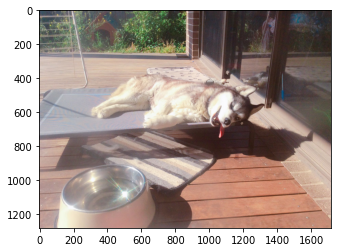

The 2 mammal is:dogs


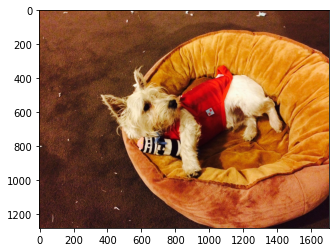

The 3 mammal is:dogs


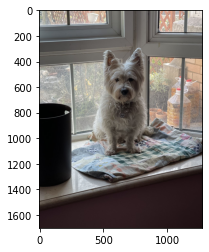

The 4 mammal is:dogs


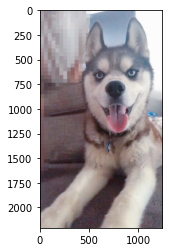

The 5 mammal is:dogs


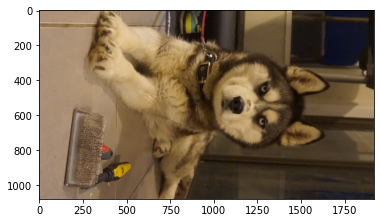

The 6 mammal is:cat


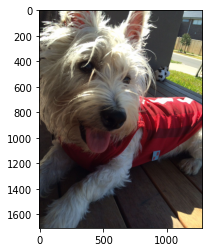

The 7 mammal is:cat


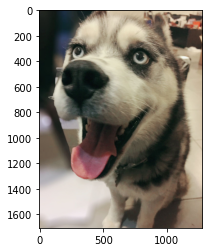

The 8 mammal is:dogs


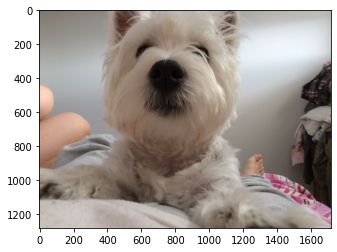

The 9 mammal is:dogs


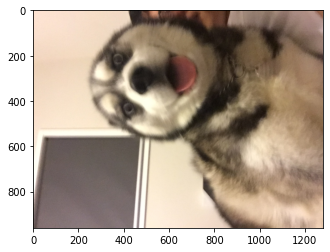

The 10 mammal is:dogs


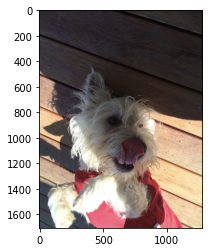

The 11 mammal is:dogs


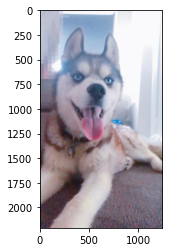

The 12 mammal is:dogs


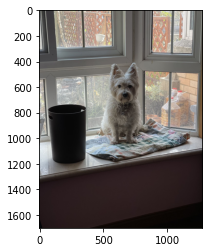

The 13 mammal is:dogs


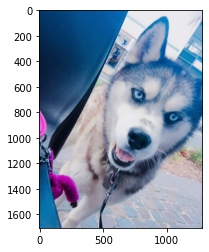

In [25]:
# Plotting predicted images

print(prediction)
print(np.size(prediction))

for i in range(np.size(prediction)):
    # Print predictions for each image
    print("The",i+1,"mammal is:" + mammal_dict[prediction[i]]) # Predict the labels returned for 01234 and turn him into an animal species into a list  

    img = plt.imread(correction[i]) 
    plt.imshow(img)
    plt.show()   